In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import cv2
from urllib.request import urlretrieve
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
train_dataset = torchvision.datasets.CelebA(root="../data", split="train", transform=ToTensor(), download=True, target_transform=None)
test_dataset = torchvision.datasets.CelebA(root="../data", split="test", transform=ToTensor(), download=True, target_transform=None)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
class_names = train_dataset.attr_names[:-1]
len(class_names)

40

In [4]:
train_dataset = DataLoader(train_dataset, 32, True)
test_dataset = DataLoader(test_dataset, 32, shuffle=False)

In [5]:
batch, images = next(iter(train_dataset))
batch.shape, images.shape

(torch.Size([32, 3, 218, 178]), torch.Size([32, 40]))

In [6]:
batch[0].device

device(type='cpu')

torch.Size([3, 218, 178])
torch.Size([218, 178, 3])
torch.Size([40])
The person has/is: Eyeglasses
The person has/is: Goatee
The person has/is: High_Cheekbones
The person has/is: Male
The person has/is: Mouth_Slightly_Open
The person has/is: Smiling


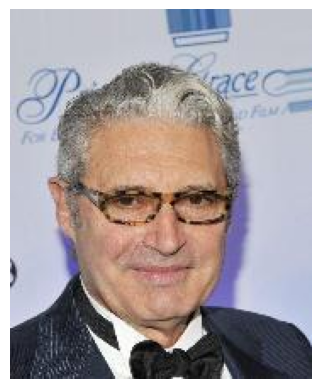

In [7]:
image = batch[5]
print(image.shape)
permuted = image.permute(1, 2, 0)
print(permuted.shape)
plt.imshow(permuted) # imshow requires this order (Width, Height, Color channels)
plt.axis(False)
print(images[0].shape)
features = list(images)
for i in range(len(class_names)):
    if (images[0][i] == 1):
        print("The person has/is: %s" % (class_names[i]))

In [8]:
def load_model():
  model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', weights="DeepLabV3_ResNet50_Weights.DEFAULT")
  model.eval()
  return model

def make_transparent_foreground(pic, mask):
  # split the image into channels
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  # add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # merge the alpha channel back
  alpha_im = cv2.merge([b, g, r, a], 4)
  # create a transparent background
  bg = np.zeros(alpha_im.shape)
  # setup the new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

  return foreground

def remove_background(model, input_file):
  input_image = input_file
  preprocess = torchvision.transforms.Compose([
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)

  return foreground, bin_mask

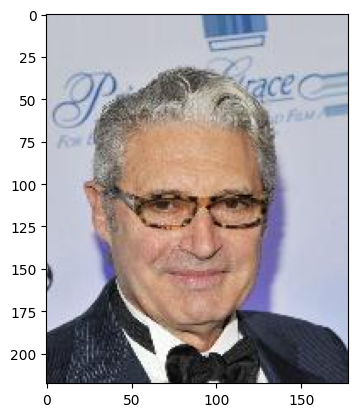

In [9]:
img = Image.fromarray((image.permute(1, 2, 0).numpy() * 255).astype(np.uint8))
plt.imshow(img)

In [10]:
deeplab_model = load_model()

Using cache found in /home/arp/.cache/torch/hub/pytorch_vision_v0.10.0


In [11]:
foreground, bin_mask = remove_background(deeplab_model, img)

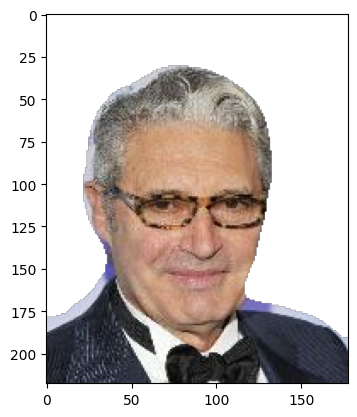

In [12]:
plt.imshow(foreground)

In [13]:
# import os
# path = "../data/celeba/img_align_celeba"
# data_files = os.listdir(path)
# for i in range(len(data_files)):
#     if data_files[i].endswith(".jpg"):
#         img = Image.open(path + "/" + data_files[i]).convert("RGB")
#         foreground, bin_mask = remove_background(deeplab_model, img)
#         img = Image.fromarray((foreground).astype(np.uint8)).convert("RGB")
#         img.save("../data/celeba/processed/" + data_files[i])

In [14]:
from typing import Callable

In [48]:
class Model(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        # a group of Conv2d, ReLu and MaxPool2d is called a "conv block"
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Calculate the size of the feature map after the convolutional layers
        # test_input = torch.randn(1, input_shape, 218, 178)
        # test_output = self.conv_block_1(test_input)
        # test_output = self.conv_block_2(test_output)
        # feature_map_size = test_output.numel() // test_output.size(0)  # Flatten the output
        # print(feature_map_size)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=43*53, out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print("Out shape after conv block 1:", x.shape)
        x = self.conv_block_2(x)
        # print("Out shape after conv block 2:", x.shape)
        x = self.classifier(x)
        # print("Out shape after conv block 3:", x.shape)
        return x

In [50]:
torch.manual_seed(42)
# input shape is the number of color channels (1 for grayscale)
model = Model(input_shape=3, hidden_units=10, output_shape=len(class_names))
model

Model(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2279, out_features=40, bias=True)
  )
)

In [17]:
import tqdm.auto as tqdm

# 4 Make predictions and get model_0 results
def eval_model(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                device: torch.device = "cpu"):
    loss, acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            torch.cuda.empty_cache()
            # Send data to target device
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            y_pred = model(X)
            # 2. Calculate loss and accuracy
            loss += loss_fn(y_pred, y)
            # For accuracy, need the prediction labels (logits -> pred labels)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with nn.Module
            "model_loss": loss.item(),
            "model_acc": acc}

In [36]:
def test_step(model: nn.Module, 
              test_dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              accuracy_fn: Callable,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    
    with torch.inference_mode():
        for i, (X, y) in enumerate(test_dataloader):
            torch.cuda.empty_cache()
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X[i])
            # 2. Calculate loss
            test_loss += loss_fn(test_pred, y[i])
            # 3. Calculate accuracy
            test_acc += accuracy_fn(y[i], test_pred.argmax(dim=1)) # go from logits -> pred labels

            if i == 50:
                break

        # Calculate the test loss average per batch
        test_loss /= len(i * 32) # len(test_dataloader)
        test_acc /= len(i * 32) # len(test_dataloader)
        print(f"\nTest loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [38]:
def train_step(model: nn.Module,
               train_dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               accuracy_fn: Callable,
               device: torch.device = device):
    
    """Performs a training with model trying to learn on train_dataloader"""
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train() # train mode

    for i, (X, y) in enumerate(train_dataloader):
        torch.cuda.empty_cache()
        X, y = X.to(device), y.to(device)
        # 1. Forward pass
        print(i, X.shape, y.shape)
        y_logit = model(X[i])
        y_pred = torch.softmax(y_logit, dim=1)
        # 2. Calculate loss
        loss = loss_fn(y_pred, y.to(torch.float)[i])
        train_loss += loss # accumulate train loss
        train_acc += accuracy_fn(y[i], torch.ceil(y_pred)) # go from logits -> pred labels
        # 3. Optimizer zero grad
        optimizer.zero_grad()
        # 4. Loss backward
        loss.backward()
        # 5. Optimizer step
        optimizer.step()

        if i == 50:
            break

    # Divide total train loss and acc by length of train dataloader
    train_loss /= len(i * 32) # len(train_dataloader)
    train_acc /= len(i * 32) # len(train_dataloader)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [54]:
h = torch.rand((32, 40))
torch.round(h)

tensor([[0., 1., 1.,  ..., 0., 1., 1.],
        [0., 1., 1.,  ..., 0., 1., 1.],
        [0., 1., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 1., 1.,  ..., 0., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 1., 0.]])

In [20]:
def train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

from torchmetrics import Accuracy

accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names))

In [22]:
print(image.shape)

torch.Size([3, 218, 178])


In [51]:
from tqdm.auto import tqdm
torch.manual_seed(42)
from timeit import default_timer as timer
train_start = timer()
epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(model, train_dataset, loss_fn, optimizer, accuracy_fn)
    test_step(model, test_dataset, loss_fn, accuracy_fn)

train_end = timer()
total_train_time_model_0 = train_time(start=train_start, end=train_end, device=str(next(model.parameters()).device))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
---------
0 torch.Size([32, 3, 218, 178]) torch.Size([32, 40])


ValueError: Expected input batch_size (10) to match target batch_size (40).